In [25]:
#import and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import shap
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(42)

In [26]:
#read in dataset
data = pd.read_csv('dataset.csv', parse_dates=['Date'], index_col='Date')

# Handle missing values
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

data.head()

<ipython-input-26-f6056624a6ad>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
Date,,,,,,,,,,,,
1998-01-01,87.616,274732,4.0,99.994570,6.9940,73.705376,1555.0,137.3,4.0562,102.5385,2.16,10.024
1998-02-01,88.004,274943,3.9,99.980549,7.0425,73.776106,1647.0,137.5,4.0889,102.7129,2.16,10.024
1998-03-01,88.443,275175,4.1,99.975298,7.1275,73.798698,1605.0,137.5,4.1143,102.7210,2.16,10.024
1998-04-01,88.879,275434,4.0,99.984454,7.1400,73.869665,1547.0,137.9,4.1402,102.6981,2.03,9.668
1998-05-01,89.365,275700,3.9,100.013988,7.1440,73.880942,1554.0,137.6,4.1644,102.5923,2.03,9.668


In [27]:
# Feature Engineering - More sophisticated time-series features
target = 'house_price_index'

# Create lagged features (1-12 months)
for lag in range(1, 13):
    data[f'hpi_lag_{lag}'] = data[target].shift(lag)

# Rolling statistics
for window in [3, 6, 12]:
    data[f'hpi_rolling_mean_{window}'] = data[target].rolling(window=window).mean()
    data[f'hpi_rolling_std_{window}'] = data[target].rolling(window=window).std()
    data[f'hpi_rolling_min_{window}'] = data[target].rolling(window=window).min()
    data[f'hpi_rolling_max_{window}'] = data[target].rolling(window=window).max()

# Percentage changes
for period in [1, 3, 6, 12]:
    data[f'hpi_pct_change_{period}'] = data[target].pct_change(period)

In [28]:
# Economic indicator interactions
data['gdp_hpi_ratio'] = data['gdp'] / data[target]
data['mortgage_employment_ratio'] = data['mortgage_rate'] / data['employment_rate']

# Drop rows with NaN from feature engineering
data.dropna(inplace=True)

# Define features and target
features = [col for col in data.columns if col != target]
X = data[features]
y = data[target]

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []


In [29]:
# Custom metric for XGBoost
def percentage_error(preds, dtrain):
    labels = dtrain.get_label()
    return 'percentage_error', np.mean(np.abs((preds - labels) / labels))

# Custom objective function (weighted combination of squared error and percentage error)
def custom_obj(preds, dtrain):
    labels = dtrain.get_label()
    grad = (preds - labels) + 0.5 * (preds - labels) / (np.abs(labels) + 1e-6)
    hess = np.ones_like(preds) + 0.5 / (np.abs(labels) + 1e-6)
    return grad, hess

In [30]:
# Optimized XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'n_estimators': 2000,
    'random_state': 42,
    'early_stopping_rounds': 100
}

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
# Time-series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dtrain, 'train'), (dtest, 'test')],
        feval=percentage_error,
        verbose_eval=100,
        obj=custom_obj
    )

    y_pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse:.4f}")

print(f"\nAverage RMSE across folds: {np.mean(rmse_scores):.4f}")


[0]	train-rmse:109.29921	train-percentage_error:0.98564	test-rmse:161.88308	test-percentage_error:0.99020
[100]	train-rmse:42.20826	train-percentage_error:0.36999	test-rmse:93.37948	test-percentage_error:0.55718


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:16.74573	train-percentage_error:0.14203	test-rmse:64.66408	test-percentage_error:0.37166
[300]	train-rmse:6.81214	train-percentage_error:0.05520	test-rmse:52.12104	test-percentage_error:0.28837
[400]	train-rmse:2.89985	train-percentage_error:0.02188	test-rmse:46.74214	test-percentage_error:0.25154
[500]	train-rmse:1.34870	train-percentage_error:0.00914	test-rmse:44.30100	test-percentage_error:0.23437
[600]	train-rmse:0.74626	train-percentage_error:0.00404	test-rmse:43.35698	test-percentage_error:0.22758
[700]	train-rmse:0.50259	train-percentage_error:0.00217	test-rmse:42.86247	test-percentage_error:0.22408
[800]	train-rmse:0.38182	train-percentage_error:0.00148	test-rmse:42.58840	test-percentage_error:0.22213
[900]	train-rmse:0.31572	train-percentage_error:0.00119	test-rmse:42.41311	test-percentage_error:0.22093
[1000]	train-rmse:0.27265	train-percentage_error:0.00103	test-rmse:42.30218	test-percentage_error:0.22023
[1100]	train-rmse:0.23906	train-percentage_error:0.00

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:20.26425	train-percentage_error:0.13918	test-rmse:15.91389	test-percentage_error:0.06761
[300]	train-rmse:7.92625	train-percentage_error:0.05285	test-rmse:16.36816	test-percentage_error:0.09542
[400]	train-rmse:3.13393	train-percentage_error:0.02025	test-rmse:21.77695	test-percentage_error:0.12364
[500]	train-rmse:1.27750	train-percentage_error:0.00796	test-rmse:24.25604	test-percentage_error:0.13889
[600]	train-rmse:0.55438	train-percentage_error:0.00327	test-rmse:25.00633	test-percentage_error:0.14366
[700]	train-rmse:0.27827	train-percentage_error:0.00147	test-rmse:25.25468	test-percentage_error:0.14521
[800]	train-rmse:0.17410	train-percentage_error:0.00085	test-rmse:25.32358	test-percentage_error:0.14563
[900]	train-rmse:0.13196	train-percentage_error:0.00064	test-rmse:25.33842	test-percentage_error:0.14573
[1000]	train-rmse:0.10959	train-percentage_error:0.00053	test-rmse:25.34960	test-percentage_error:0.14580
[1100]	train-rmse:0.09442	train-percentage_error:0.00

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:20.71335	train-percentage_error:0.13753	test-rmse:19.35524	test-percentage_error:0.12867
[300]	train-rmse:7.96853	train-percentage_error:0.05182	test-rmse:7.17088	test-percentage_error:0.04555
[400]	train-rmse:3.10695	train-percentage_error:0.01961	test-rmse:2.88896	test-percentage_error:0.01688
[500]	train-rmse:1.25336	train-percentage_error:0.00760	test-rmse:1.91233	test-percentage_error:0.01164
[600]	train-rmse:0.54018	train-percentage_error:0.00307	test-rmse:1.81089	test-percentage_error:0.01023
[700]	train-rmse:0.26917	train-percentage_error:0.00138	test-rmse:1.83086	test-percentage_error:0.00995
[800]	train-rmse:0.16563	train-percentage_error:0.00085	test-rmse:1.84061	test-percentage_error:0.00982
[900]	train-rmse:0.12484	train-percentage_error:0.00065	test-rmse:1.84509	test-percentage_error:0.00977
[1000]	train-rmse:0.10358	train-percentage_error:0.00054	test-rmse:1.84876	test-percentage_error:0.00975
[1100]	train-rmse:0.08939	train-percentage_error:0.00047	test

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:20.56243	train-percentage_error:0.13640	test-rmse:36.49955	test-percentage_error:0.18897
[300]	train-rmse:7.84958	train-percentage_error:0.05111	test-rmse:19.86658	test-percentage_error:0.09595
[400]	train-rmse:3.03064	train-percentage_error:0.01922	test-rmse:13.49591	test-percentage_error:0.05904
[500]	train-rmse:1.20598	train-percentage_error:0.00737	test-rmse:11.22399	test-percentage_error:0.04516
[600]	train-rmse:0.51601	train-percentage_error:0.00295	test-rmse:10.25819	test-percentage_error:0.03951
[700]	train-rmse:0.26297	train-percentage_error:0.00137	test-rmse:9.77636	test-percentage_error:0.03682
[800]	train-rmse:0.17256	train-percentage_error:0.00085	test-rmse:9.57014	test-percentage_error:0.03569
[900]	train-rmse:0.13706	train-percentage_error:0.00067	test-rmse:9.48004	test-percentage_error:0.03521
[1000]	train-rmse:0.11769	train-percentage_error:0.00057	test-rmse:9.44680	test-percentage_error:0.03505
[1100]	train-rmse:0.10388	train-percentage_error:0.00051	

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:21.56776	train-percentage_error:0.13574	test-rmse:80.35974	test-percentage_error:0.30555
[300]	train-rmse:8.24872	train-percentage_error:0.05067	test-rmse:60.73324	test-percentage_error:0.21103
[400]	train-rmse:3.21160	train-percentage_error:0.01902	test-rmse:52.31618	test-percentage_error:0.16762
[500]	train-rmse:1.30710	train-percentage_error:0.00727	test-rmse:48.72004	test-percentage_error:0.14811
[600]	train-rmse:0.59541	train-percentage_error:0.00290	test-rmse:47.12862	test-percentage_error:0.13914
[700]	train-rmse:0.34576	train-percentage_error:0.00139	test-rmse:46.46951	test-percentage_error:0.13516
[800]	train-rmse:0.25406	train-percentage_error:0.00094	test-rmse:46.12638	test-percentage_error:0.13300
[900]	train-rmse:0.21349	train-percentage_error:0.00079	test-rmse:45.91824	test-percentage_error:0.13173
[1000]	train-rmse:0.18736	train-percentage_error:0.00071	test-rmse:45.81410	test-percentage_error:0.13102
[1100]	train-rmse:0.16736	train-percentage_error:0.00

In [32]:
# Final model training on full dataset (80% train, 20% test)
split_idx = int(len(data) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=params['n_estimators'],
    evals=[(dtrain, 'train'), (dtest, 'test')],
    feval=percentage_error,
    verbose_eval=100,
    obj=custom_obj
)

[0]	train-rmse:149.93192	train-percentage_error:0.98668	test-rmse:227.79264	test-percentage_error:0.99009
[100]	train-rmse:56.15953	train-percentage_error:0.36590	test-rmse:120.97991	test-percentage_error:0.50499


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	train-rmse:21.13908	train-percentage_error:0.13604	test-rmse:79.07426	test-percentage_error:0.30779
[300]	train-rmse:8.05418	train-percentage_error:0.05078	test-rmse:62.71188	test-percentage_error:0.22643
[400]	train-rmse:3.13786	train-percentage_error:0.01905	test-rmse:55.38984	test-percentage_error:0.18791
[500]	train-rmse:1.28579	train-percentage_error:0.00728	test-rmse:51.97029	test-percentage_error:0.16916
[600]	train-rmse:0.59127	train-percentage_error:0.00287	test-rmse:50.30497	test-percentage_error:0.15984
[700]	train-rmse:0.34565	train-percentage_error:0.00132	test-rmse:49.46955	test-percentage_error:0.15516
[800]	train-rmse:0.25371	train-percentage_error:0.00088	test-rmse:48.97328	test-percentage_error:0.15238
[900]	train-rmse:0.20994	train-percentage_error:0.00075	test-rmse:48.63795	test-percentage_error:0.15051
[1000]	train-rmse:0.18205	train-percentage_error:0.00068	test-rmse:48.40119	test-percentage_error:0.14919
[1100]	train-rmse:0.16219	train-percentage_error:0.00

In [33]:
# Predictions
y_pred_train = final_model.predict(dtrain)
y_pred_test = final_model.predict(dtest)

# Evaluation metrics
def evaluate(y_true, y_pred, prefix):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pct_error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    within_10 = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    within_20 = np.mean(np.abs((y_true - y_pred) / y_true) < 0.20) * 100

    print(f"\n{prefix} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Mean Percentage Error: {pct_error:.2f}%")
    print(f"Within ±10%: {within_10:.2f}%")
    print(f"Within ±20%: {within_20:.2f}%")

    return rmse, mae, r2

# Evaluate performance
train_rmse, train_mae, train_r2 = evaluate(y_train, y_pred_train, "Training")
test_rmse, test_mae, test_r2 = evaluate(y_test, y_pred_test, "Test")


Training Metrics:
RMSE: 0.0814
MAE: 0.0527
R²: 1.0000
Mean Percentage Error: 0.04%
Within ±10%: 100.00%
Within ±20%: 100.00%

Test Metrics:
RMSE: 47.5422
MAE: 36.0878
R²: -1.3471
Mean Percentage Error: 14.44%
Within ±10%: 47.37%
Within ±20%: 71.93%


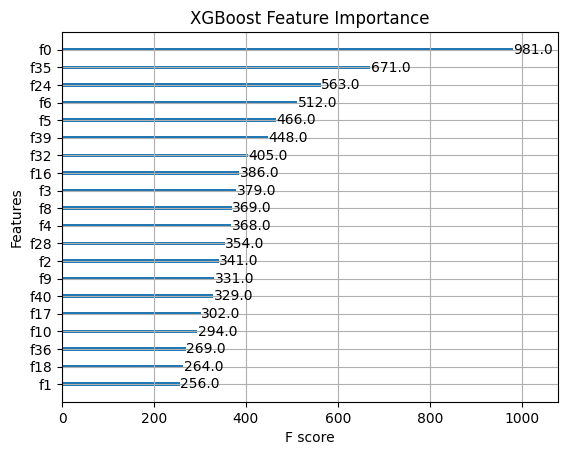

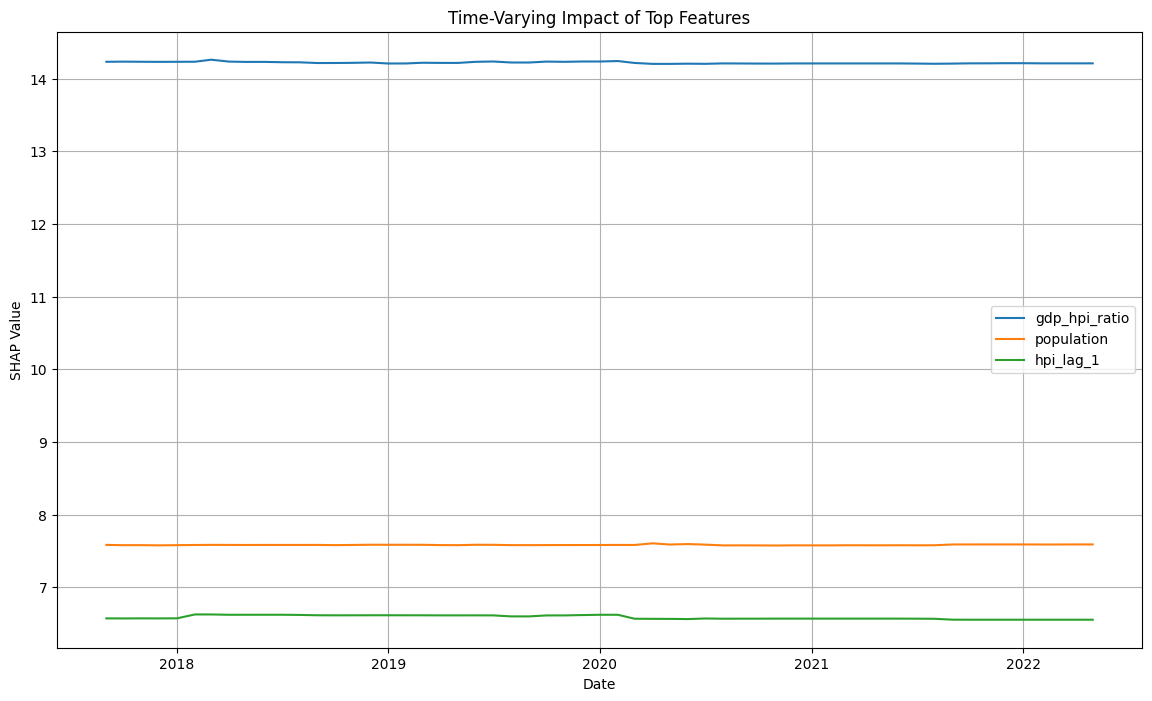

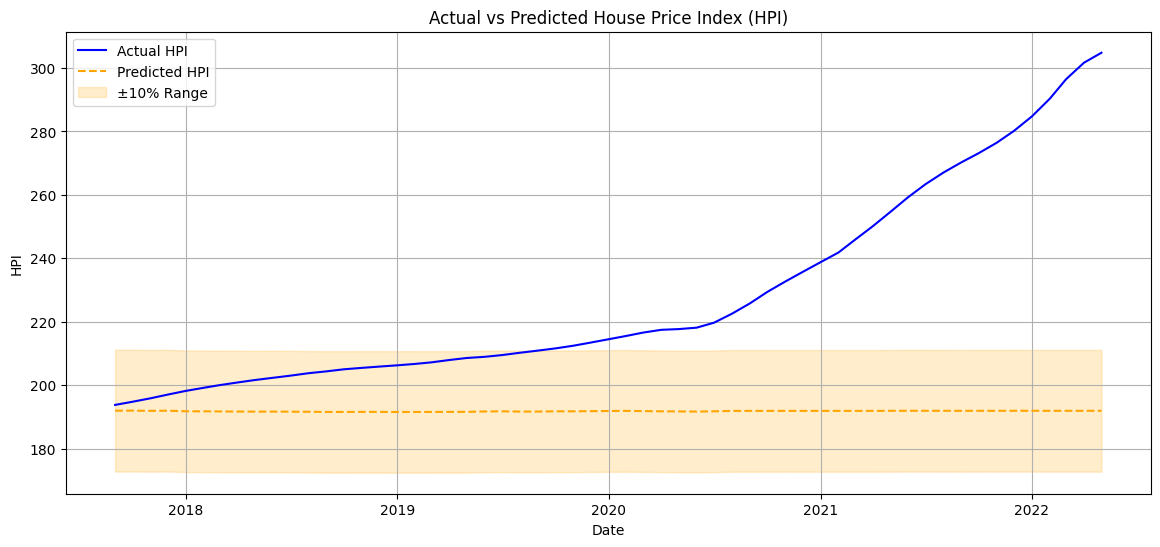

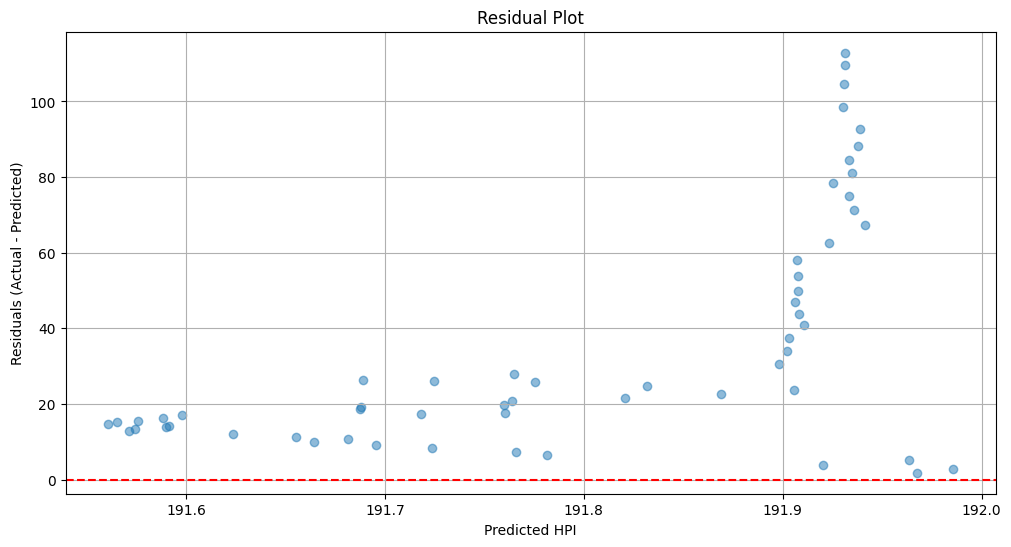

In [34]:
# Feature Importance
xgb.plot_importance(final_model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.show()

# SHAP Analysis
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)


# Time-varying impact analysis
shap_df = pd.DataFrame(shap_values, columns=features, index=y_test.index)

# Plot impact of top 3 features over time
top_features = np.abs(shap_df).mean().sort_values(ascending=False).index[:3]
plt.figure(figsize=(14, 8))
for feature in top_features:
    plt.plot(shap_df.index, shap_df[feature], label=feature)
plt.title('Time-Varying Impact of Top Features')
plt.xlabel('Date')
plt.ylabel('SHAP Value')
plt.legend()
plt.grid()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual HPI', color='blue')
plt.plot(y_test.index, y_pred_test, label='Predicted HPI', color='orange', linestyle='--')
plt.fill_between(
    y_test.index,
    y_pred_test * 0.9,
    y_pred_test * 1.1,
    color='orange',
    alpha=0.2,
    label='±10% Range'
)
plt.title('Actual vs Predicted House Price Index (HPI)')
plt.xlabel('Date')
plt.ylabel('HPI')
plt.legend()
plt.grid()
plt.show()

# Residual analysis
residuals = y_test - y_pred_test
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted HPI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid()
plt.show()